<a href="https://colab.research.google.com/github/differential-machine-learning/notebooks/blob/master/DifferentialPCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Differential PCA

---
Brian Huge & Antoine Savine, August 2021
---


This notebook implements differential PCA, an application of <b> differential machine learning </b> to dimension reduction. Differential ML was introduced in our October 2020 Risk article [Differential Machine Learning: the Shape of Things to Come](https://www.risk.net/cutting-edge/banking/7688441/differential-machine-learning-the-shape-of-things-to-come). Its main promise is the design of novel, more effective, ML algorithms based on the availability of <b> differential labels </b>. Classic datasets in machine learning include inputs $X\in\mathbb{R}^n$ and labels $Y \in \mathbb{R}$. Differential labels are defined as the gradients of labels $Y$ wrt inputs $X$:
    
        
$$Z^{\left(i\right)} \equiv \frac{\partial Y^{\left(i\right)}}{\partial X^{\left(i\right)}} \in \mathbb{R}^n$$
    
Differential labels are easily and efficiently computed with [algorithmic adjoint differentiation (AAD)](https://sites.google.com/view/antoinesavine-aad) in some situations, like simulated datasets in finance.

Differential PCA leverages differential labels to perform dimension reduction in a safer and more effective manner than classic PCA or other classic dimension reduction algorithms. Differential PCA is introduced in our October 2021 follow-up Risk article <b> Axes that matter: PCA with a difference. </b> Classic PCA projects data on axes of orthogonal variation and truncates coordinates on axes of insignificant variation. We demonstrate in the article that classic PCA is unsafe and ineffective in financial applications, because variation is not the correct metric. Small variations in the input space may have large repercutions on a given Derivatives transaction or trading book, so PCA may unwillingly truncate critical information from the data. Conversely, directions of large variation may be irrelevant for the target, preventing PCA to reduce dimension as much as would be otherwise possible. 

By contrast, differential PCA projects data on axes of principal <b> relevance</b>, defined as the magnitude of directional derivative sensitivities, and revealed by singular value decomposition (SVD) of the differential data $Z$. We demonstrate in the paper that differential PCA is safe, in the sense that it guarantees that no information meaningful for the target may be lost in dimension reduction. It is also effective, in the sense that further (linear) dimension reduction cannot be performed without deletion of meaningful information. 

Differential PCA is discussed in detail in the article. This notebook provides an implementation, along with basic application examples. The follow-up notebook [Bermudan5F.ipynb](https://github.com/differential-machine-learning/notebooks/blob/master/Bermudan5F.ipynb) applies differential PCA to the practical problem of Bermudan swaptions, illustrating the shortcomings of classic PCA in a context of practical relevance where we also illustrate the properties and benefits of the differential counterpart, and demonstrate its application to identify Derivatives risks from simulated data.

# Imports

In [1]:
if 'google.colab' in str(get_ipython()):
    colab = True
    print('Running on CoLab')
else:
    colab = False
    # enable full width for wide figures
    from IPython.core.display import display, HTML
    display(HTML("<style>.container { width:100% !important; }</style>"))
    display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
    print('Not running on CoLab')

if colab:
  %matplotlib inline
else:
  %matplotlib notebook

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
if colab == True: mpl.rc('animation', html='jshtml')

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV  
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.pipeline import make_pipeline

from scipy.stats import norm # cumulative normal distribution

# enable full width for wide figures
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))

# constants
epsilon = 1.0e-08

Not running on CoLab


# Implementation of differential PCA

The <b> DiffPCA </b> class defined below implements differential PCA with an API similar to [scikit-learn's PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to project data on axes of principal relevance revealed by eigenvalue decomposition of the covariance matrix of differential data. 

The constructor takes 2 parameters: <i> n_components </i> and <i> central </i>. 
The parameter <i> n_components </i> is identical to scikit-learn's PCA: if omitted, data is re-paramterized in terms of coordinates on axes othogonal and decreasing relevance, but no dimension reduction is performed. If <i> n_components </i> is a positive integer, the data is projected on the <i> n_components </i> principal axes of relevance, truncating coordinates on the remaining <i> n_features - n_components </i> axes, where <i> n_features </i> is the original dimension of the data. If <i> n_components </i> is a real number between 0 and 1, dimension reduction is set to explain at least the proportion <i> n_components </i> of the total relevance, in other terms, the (squared) error of projected gradients (denoted $\epsilon$ in the article) is smaller than  <i> 1 - n_components </i>.
The parameter <i> central </i> may be set to perform central differential PCA, as discussed in the article. Default is non-central DPCA, the correct alternative for most applications.

The <i> fit </i> method performs differential PCA, i.e. eigenvalue decomposition of gradient covariance. It takes input data $X$ and differential data $Z$ for compulsory arguments. For consistency with scikit-learn's PCA, it also takes labels $y$ as an optional argument, which is ignored.
Results are available after fitting in the following attributes:
- <i> n_samples_ </i> (integer) the number of training examples
- <i> n_features_ </i> (integer) the dimension of original data
- <i> mean_ </i> (vector of dimension n_features_) the means of the original data columns
- <i> n_components_ </i> (integer) the reduced dimension
- <i> components_ </i> (matrix of dimension n_components_ x n_features_) the n_components_ axes of relevance, represented by (othogonal) unit vectors and sorted by decreasing relevance
- <i> explained_variance_ </i> (vector of dimension n_components_) the relevance (gradient magnitude) of the n_components_ principal axes
- <i> explained_variance_ratio_ </i> (vector of dimension n_components_) = explained_variance_ / total_relevance (sum of relevances of the n_features_ axes)
- <i> singular_values_ </i> (vector of dimension n_components_) = sqrt (explained_variance_)
- <i> noise_variance_ </i> (vector of dimension n_components_) = total_relevance - sum (explained_variance_)

The <i> transform </i> method performs dimension reduction by projecting some data $X$ onto the principal components computed by <i> fit </i>. This method can also project derivatives $Z=\partial V / \partial X$. If $Z$ is passed, the derivatives wrt reduced data $L$ (for 'latent'),  $S=\partial V / \partial L$, is returned along with reduced data $L$.

As customary in scikit-learn, <i> fit_transform </i> combines  <i> fit </i> and <i> transform </i> and <i> inverse_transform </i> reconstructs $X$ (and optionally $Z$) from $L$ (and optionally $S$). Reconstruction is performed in the least-square sense, the information lost in truncation cannot be recovered.

In [2]:
class DiffPCA:
    
    def __init__(self, n_components=None, central=False):
        """
        The API is consistent with sklearn.decomposition.PCA 
        (see https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
        
        n_components = number of components to keep. If n_components is None all components are kept:
        n_components == n_features
        
        If 0 < n_components < 1, select the number of components such that 
        the amount of 'variance' (squared magnitude) that needs to be explained is greater than the percentage specified by n_components
        
        Default = squared error magnitude (epsilon*total_variance in the article) of 10^(-8), i.e. error norm is 0.01% of total norm
                        
        central = specific to differential PCA, standard scikit-learn PCA is always central. By contrast, 
        differential PCA is noncentral by default, see article
        """
        
        self.n_components = n_components
        self.central = central
        
    def fit(self, X, Z, y=None): # note y is ignored, just like in scikit-learn PCA
        """
        X: input data
        Z: differential data = dy/dZ, see article
        (y: labels)
        """
        
        # data shape
        self.n_samples_, self.n_features_ = X.shape
        
        # central?
        self.mean_ = Z.mean(axis=0) # average differentials
            
        # compute covariance matrix of differentials
        z = Z - self.mean_ if self.central else Z
        self.cov_ = z.T @ z / self.n_samples_
        
        # eigenvalue decomposition
        d, P = np.linalg.eigh(self.cov_)
                
        # reverse order so largest eigenvalues come first
        d = d[::-1]
        P = P[:, ::-1]
        
        sumd = np.cumsum(d)
        total_variance = sumd[-1]

        # find the number of principal components
        if self.n_components is not None: 
            # n_components is larger than 1 = number of components
            if self.n_components >= 1:
                self.n_components_ = self.n_components
            # n_components is smaller than 1 = square magnitude explained
            else:
                sumd /= total_variance
                self.n_components_ = np.searchsorted(sumd, self.n_components) + 1
            
        else:
            self.n_components_ = min(self.n_samples_, self.n_features_)
            
        explained = sumd[self.n_components_-1]
        unexplained = total_variance - explained

        # filter irrelevant components
        d = d[:self.n_components_]
        P = P[:, :self.n_components_]
            
        # results, attributes as in sklearn.decomposition.PCA
        self.components_ = P.T
        self.explained_variance_ = d
        self.explained_variance_ratio_ = d / total_variance
        self.singular_values_ = np.sqrt(d)
        self.noise_variance_ = unexplained
        
    def transform(self, X, Z=None): 
        
        # transformed dataset
        L = X @ self.components_.T
        
        if Z is None:
            return L
        
        else:
            # transformed derivatives
            S = Z @ self.components_.T
            return L, S
        
    def fit_transform(self, X, Z, y=None):
        self.fit(X, Z, y)
        return self.transform(X, Z)
    
    def inverse_transform(self, L, S=None):
        
        # L to X
        X = L @ self.components_
        
        if S is None:
            return X
        
        else:
            # S to Z
            Z = S @ self.components_
            return X, Z

# Bachelier basket dataset

We demonstrate differential PCA with a basic Bachelier basket simulator, similar to the ones implemented in [DifferentialML.ipynb](https://github.com/differential-machine-learning/notebooks/blob/master/DifferentialML.ipynb) for the demonstration of differential neural networks, and [DifferentialRegression.ipynb](https://github.com/differential-machine-learning/notebooks/blob/master/DifferentialRegression.ipynb) for the demonstration of differential regression. We start with an implementation of Bachelier analytics, so we can compare results with correct prices. 

In [3]:
# Bachelier analytics 

def Bachelier(S, K, sigma, T):
    d = (S - K) / sigma / np.sqrt(T)
    return  sigma * np.sqrt(T) * (d * norm.cdf(d) + norm.pdf(d))

def BachelierDelta(S, K, sigma, T):
    d = (S - K) / sigma / np.sqrt(T)
    return norm.cdf(d)

Next, we have some helper functions to randomly generate model configurations: stock volatility and correlation.

In [4]:
# Helpers to generate random volatilities and correlations for the stock market

# generates random stock volatilities
def genVols(num_stocks, lower=5, upper=50):
    vols = np.random.uniform(low=lower, high=upper, size=(num_stocks, 1))
    return vols

# generates a random correlation matrix
def genCorrel(num_stocks):
    randoms = np.random.uniform(low=-1., high=1., size=(2*num_stocks, num_stocks))
    cov = randoms.T @ randoms
    invvols = np.diag(1. / np.sqrt(np.diagonal(cov)))
    return np.linalg.multi_dot([invvols, cov, invvols])



Next, we have more helper functions to conveniently generate basket options with random basket weights, strike and notional. We also have functions to randomly set basket volatility and scale basket weights accordingly. 

In [5]:
# Helpers to generate random basket options

# generates random notional
def genNotional(lower=1, upper=10):
    notional = np.random.uniform(low=lower, high=upper)
    return notional

# generates random strike
def genStrike(lower=50, upper=150):
    strike = np.random.uniform(low=lower, high=upper)
    return strike

# generates random positive weights summing to 1
def genWeights(num_stocks):
    w = np.random.uniform(size=(num_stocks, 1))
    return w / w.sum()

# generates a random basket volatility
def genBktVol(lower=10, upper=30):
    bkt_vol = np.random.uniform(low=lower, high=upper)
    return bkt_vol

# compute basket volatility
def basketVol(weights, stock_vols, stock_correl):
    weighted_vols = weights * stock_vols
    bkt_vol = np.sqrt(np.linalg.multi_dot([weighted_vols.T, stock_correl, weighted_vols])).item()
    return bkt_vol

Next, we have a basic structure to hold the parameters of a basket option, and functions to create basket options, either randomly or with given parameters, and update weights to match given basket volatility.

In [6]:
# basket structure

from collections import namedtuple
Basket = namedtuple("Basket", "notional strike weights")

# create a basket option
def makeBasket(num_stocks, notional=None, strike=None, weights=None): # None = generate randomly
    
    n = genNotional() if notional is None else notional
    k = genStrike() if strike is None else strike    
    w = genWeights(num_stocks) if weights is None else np.array(weights).reshape(num_stocks, 1)
    
    return Basket(n, k, w)

# update weights and strike to match some target basket volatility
def updateBasket(basket, stock_vols, stock_correl, tgt_bkt_vol=None):
    
    bkt_vol = basketVol(basket.weights, stock_vols, stock_correl)
    tgt = genBktVol() if tgt_bkt_vol is None else tgt_bkt_vol
    ratio = tgt / bkt_vol
    
    return Basket(basket.notional, ratio * basket.strike, ratio * basket.weights)

Finally, we have the simulator class.

The constructor takes the following arguments:
- <i> num_stocks </i> (integer) the number of stocks in the universe
- <i> num_baskets </i> (integer) the number of basket options in the book
- <i> maturity </i> (real number) the maturity of basket options in years (same for all basket options for simplicity)
- <i> stock_vols </i> (vector of dimension num_stocks) the normal stock volatilities, randomly generated if omitted
- <i> stock_correl </i> (squared matrix of dimension num_stocks) the stock correlation, randomly generated if omitted
- <i> baskets </i> (collection of num_baskets Basket objects) the parameters of the basket options, randomly generated if omitted
- <i> tgt_bkt_vols </i> (vector of dimension num_baskets) the target volatilities for the baskets (weights are rescaled accordingly), randomly generated if omitted
- <i> seed </i> (integer) the seed for random generations, 0 if omitted

The method <b> trainSet </b> generates a (differential) training set. It takes the following arguments:
- <i> num_examples </i> (integer) the number of training examples
- <i> lower, upper </i> (two real numbers) the lower and upper bounds for initial stock prices
- <i> seed </i> (integer) the seed for the Monte-Carlo simulations

It returns a (differential) training set $X$, $y$, $Z$ where:
- <i> $X$ </i> (matrix of dimension num_examples x num_stocks) are the initial stock prices
- <i> $y$ </i> (vector of dimension num_examples) are the corresponding subsequent combined payoffs of all the basket options in the portfolio, picked on one MC path with initial state $X$
- <i> $Z$ </i> (matrix of dimension num_examples x num_stocks) are the differential labels $\partial y / \partial X$

The method <b> testSet </b> generates a test set $X$, $y$, $Z$ where $X$ is an independent set of initial stock prices, $y$ are the corresponding <b> correct </b> basket option prices (actually, the sum of basket option prices in the book, i.e. correct book value) computed analytically with Bachelier's formula, and $Z$ are the deltas $\partial y / \partial X$.






In [7]:
class BachelierSimulator():
    
    # None = generate randomly
    def __init__(self, num_stocks, num_baskets, maturity, stock_vols=None, stock_correl=None, baskets=None, tgt_bkt_vols=None, seed=0):
        self.num_stocks = num_stocks
        self.num_baskets = num_baskets
        self.maturity = maturity
        self.sqrtT = np.sqrt(maturity)
        
        np.random.seed(seed)
        
        self.vols = genVols(num_stocks) if stock_vols is None else np.array(stock_vols).reshape(num_stocks, 1)
        self.correl = genCorrel(num_stocks) if stock_correl is None else np.array(stock_correl).reshape(num_stocks, num_stocks)
        
        baskets = [makeBasket(num_stocks) for _ in range(num_baskets)] if baskets is None else baskets
        self.bkt_vol = np.array([genBktVol() for _ in baskets])
        self.baskets = [updateBasket(basket, self.vols, self.correl, bkt_vol) for basket, bkt_vol in zip (baskets, self.bkt_vol)]
        
        vT = np.diag(self.vols.ravel()) * self.sqrtT
        self.cov = np.linalg.multi_dot([vT, self.correl, vT])
        self.chol = np.linalg.cholesky(self.cov) 
                
    # simulate (differential) training set, returns X, Y, Z where
    # X = initial state in dimension num_stocks = initial stock prices
    # Y = payoff of the basket option(s)
    # Z = dY / dX in dimension num_stocks, i.e. pathwise derivatives
    def trainSet(self, num_examples, lower=25, upper=175, seed=0):
        np.random.seed(seed)

        s0 = np.random.uniform(low=lower, high=upper, size=(num_examples, self.num_stocks))
        wT = np.random.normal(size=(num_examples, self.num_stocks))
        sT = s0 + wT @ self.chol.T
        
        pay, deriv = np.zeros((num_examples, 1)), np.zeros((num_examples, self.num_stocks))
        for basket in self.baskets:
            bT = np.dot(sT, basket.weights)
            pay += np.maximum(0, bT - basket.strike)
            deriv += np.where(bT > basket.strike, 1, 0).reshape(-1, 1) * basket.weights.reshape(1, -1)
        
        return s0, pay, deriv
    
    # simulate (independent) test set, returns X, Y, Z where
    # X = initial state in dimension num_stocks = initial stock prices
    # Y = price of the basket option(s)
    # Z = dY / dX in dimension num_stocks, i.e. deltas    
    def testSet(self, num_examples, lower=40, upper=160, seed=1024): # must be a different seed
        np.random.seed(seed)
        
        s0 = np.random.uniform(low=lower, high=upper, size = (num_examples, self.num_stocks))
        
        prices, deltas = np.zeros((num_examples, 1)), np.zeros((num_examples, self.num_stocks))
        for basket, vol in zip(self.baskets, self.bkt_vol):
            b0 = np.dot(s0, basket.weights)
            prices += Bachelier(b0, basket.strike, vol, self.maturity)
            deltas += BachelierDelta(b0, basket.strike, vol, self.maturity) @ basket.weights.reshape(1, -1)
        
        return s0, prices, deltas

# Differential PCA on Bachelier basket dataset: one basket option

As a first demonstration example, we simulate a training set for one basket option.

In [8]:
# test for 1 basket

num_stocks = 20
num_baskets = 1

seed = np.random.randint(131072)
print("using training seed", seed)

bach = BachelierSimulator(num_stocks, num_baskets, 3, seed=seed)

# enough examples so we don't worry about overfitting in low dimension
num_examples = 131072

x_train, y_train, z_train = bach.trainSet(num_examples, seed=seed)

num_test = 1024
test_seed = np.random.randint(131072)
print("using test seed", test_seed)

x_test, y_test, z_test = bach.testSet(num_test, seed=test_seed)

using training seed 7388
using test seed 12423


Perform differential PCA on the training set, with error tolerance $\epsilon = 10^{-8}$. 

In [9]:
# differential PCA

dpca = DiffPCA(1.0-epsilon)

# L = latent representation in low dimension, S = dY / dL
L, S = dpca.fit_transform(x_train, z_train)

Check that dimension was correctly reduced to one, as we know that basket option values only depend on the basket in the Gaussian model.

In [10]:
# dimension reduction

# initial
print(x_train.shape, z_train.shape) # 131072 x 20

# reduced
print(L.shape, S.shape) # 131072 x 1


(131072, 20) (131072, 20)
(131072, 1) (131072, 1)


Next, we check that no relevant information was lost in dimension reduction. We check this simply by learning the pricing function by polynomial regression in the reduced space, and compare with the correct pricing function on the test set. The code for polynomial regression uses scikit-learn's [PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) and [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) in a [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) and is copied from [DifferentialRegression.ipynb](https://github.com/differential-machine-learning/notebooks/blob/master/DifferentialRegression.ipynb). 

Note that the original dimension is too high to perform regression, more sophisticated learning algorithms like neural networks would be necessary for the task.

In [11]:
# polynomial regression, for tests

def make_polynomial(degree=5):
    return make_pipeline(PolynomialFeatures(degree=degree), LinearRegression(normalize=True))

poly_reg = make_polynomial()

<IPython.core.display.Javascript object>


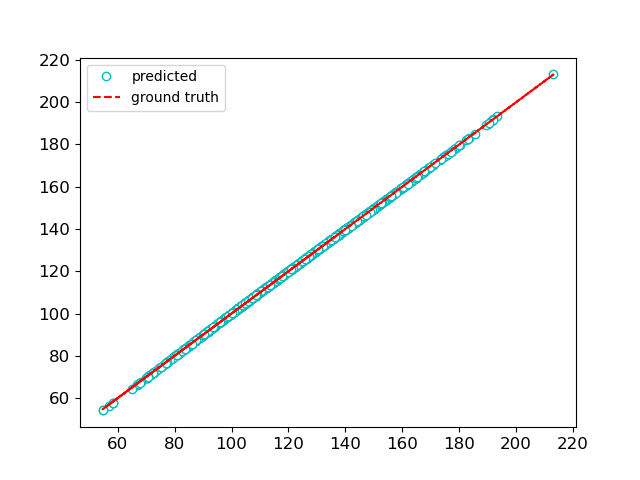

In [12]:
# polynomial regression in the reduced dimension space
poly_reg.fit(L, y_train)

# predict test set 
pred = poly_reg.predict(dpca.transform(x_test))

# plot results
plt.figure()
plt.plot(y_test, pred, 'co', markerfacecolor="white", label="predicted")
plt.plot(y_test, y_test, 'r--', label="ground truth")
plt.legend()
plt.show()

We see that the predictions match correct values, demonstrating that a correct pricing function was learned from the reduced data, hence confirming that no relevant information was truncated. Finally, we check that the one relevant axis exactly corresponds to the (scaled) basket weights. 

In [13]:
# compare principal axis to normalized basket weights

print(dpca.n_components_) #1

axis = dpca.components_[0]
weights = bach.baskets[0].weights
normalized = (weights / np.linalg.norm(weights)).ravel()

print(np.allclose(axis, normalized)) # True

1
True


As mathematically demonstrated in the article, differential PCA correctly identified that the financial product only depends on the initial basket, and correctly estimated its weights, from simulated data, without knowing anything about the product being a basket option. Differential PCA performed a drastic dimension reduction, transforming multi-dimensional stock data into one-dimensional basket data, without loss of relevant information. The polynomial regression simply approximated Bachelier's pricing function with polynomials. 

# Differential PCA on Bachelier basket dataset: multiple basket options

We easily generalize to a portoflio of multiple basket options below. Simulate training and test sets:

In [14]:
# test for 3 baskets

num_stocks = 20
num_baskets = 3

seed = np.random.randint(131072)
print("using training seed", seed)

bach3 = BachelierSimulator(num_stocks, num_baskets, 3, seed=seed)

# enough so we don't worry about overfitting in low dimension
num_examples = 131072

x_train, y_train, z_train = bach3.trainSet(num_examples, seed=seed)

num_test = 1024
test_seed = np.random.randint(131072)
print("using test seed", test_seed)

x_test, y_test, z_test = bach3.testSet(num_test, seed=test_seed)

using training seed 99607
using test seed 55405


Perform differential PCA and check that dimension was reduced to the number of baskets:

In [15]:
# differential PCA

# L = latent representation in low dimension, S = dY / dL
L, S = dpca.fit_transform(x_train, z_train)

# dimension reduction

# initial
print(x_train.shape, z_train.shape) # 131072 x 20

# reduced
print(L.shape, S.shape) # 131072 x 3

(131072, 20) (131072, 20)
(131072, 3) (131072, 3)


Perform regression on reduced data and check that no relevant information was truncated:

<IPython.core.display.Javascript object>


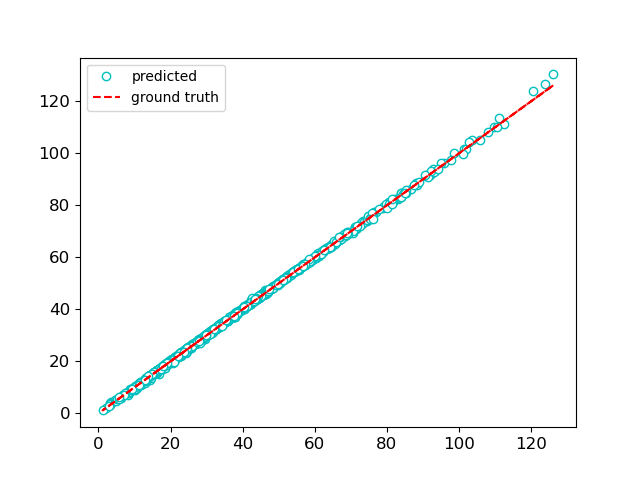

In [16]:
# polynomial regression in the reduced dimension space
poly_reg.fit(L, y_train)

# predict test set 
pred = poly_reg.predict(dpca.transform(x_test))

# compute error and plot
plt.figure()
plt.plot(y_test, pred, 'co', markerfacecolor="white", label="predicted")
plt.plot(y_test, y_test, 'r--', label="ground truth")
plt.legend()
plt.show()

And, finally, check that differential PCA correctly estimated the basket weights from data. Note that the principal components cannot correspond to the baskets, because the components are orthonormal by construction. What this means is that the principal components and the basket weights are meant to <b> span the same subspace </b>, which is easily verified below:

In [17]:
# compare principal axes to basket weights

print(dpca.n_components_) # 3

axes = dpca.components_.T # 3 principal components in columns
weights = np.array([basket.weights.ravel() for basket in bach3.baskets]).T # 3 vectors of basket weights in columns

# check that weights and axes span the same 3-dimensional subspace
# since axes are orthonormal, it is sufficient to check that weights belong to their spanned space

# project weights onto axes
projected_weights = axes @ axes.T @ weights 
# check that projection error is zero
print(np.allclose(weights, projected_weights)) # True

3
True


This concludes the implementation and basic demonstration of differential PCA. The notebook [Bermudan5F.ipynb](https://github.com/differential-machine-learning/notebooks/blob/master/Bermudan5F.ipynb) further demonstrates it in the context of Bermudan options, highliting further properties and benefits of differential PCA in an example of practical relevance. The notebooks also highlights critical differences between classic and differential PCA, and shows how differential PCA identifies the risk factors of exotic Derivatives.